# <p style="text-align: center;">Calibration sur les données de Chong et Menberg (2018)</p>

#### Chargement des librairies Python

In [1]:
import os
# os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import seaborn as sns
import pytensor.tensor as pt
import statsmodels.api as sm
import pytensor
from pytensor.tensor.slinalg import cholesky
import scipy as sp
import Predictions
from multiprocessing import Pool
from functools import partial

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Augmentation de la résolution des images affichées
%config InlineBackend.figure_format = 'retina'

# Fenêtre graphique avec grilles 
az.style.use("arviz-darkgrid")
az.rcParams["plot.max_subplots"] = 200
# Initialisation de la graine utilisée pour générer les données
seed = 2024
rng = np.random.default_rng(seed)

#### Quelques réglages préliminaire

In [3]:
# Chemin où se trouvent les fichiers contenant les données
path = "D:/Projet/Thesis/Simulations/Calibration/2023"

#### Lecture des jeux de données

In [4]:
# Lecture des deux datasets
datafield = pd.read_csv(os.path.join(path, "datafield.csv"), header = 0)
datacomp = pd.read_csv(os.path.join(path, "datacomp.csv"), header = 0)

In [5]:
# Affichage des données simulées
datacomp

Energy_consumption  Temperature_db   Relative_humidity         DNI  \
0               2168.55        5.822581           86.391129   31.071237   
1               1786.06        5.763393           80.157738  130.211310   
2               1855.44        8.790323           75.899194   96.178763   
3               1526.19        9.780556           76.040278  145.097222   
4               1184.69       14.506720           73.825269  229.633065   
..                  ...             ...                 ...         ...   
595             1112.54       19.366935           76.053763  165.936828   
596             1615.25       19.544444           75.044444  186.720833   
597             2247.08       14.143817           80.497312  129.517473   
598             3337.36        8.859722           86.420833   60.319444   
599             3660.18        7.477151           87.362903   36.568548   

     Infiltration  Mechanical_ventilation  Power_density  
0      509.089606                0.000512      10.244953  
1      509.089606                0.000512      10.244953  
2      509.089606                0.000512      10.244953  
3      509.089606                0.000512      10.244953  
4      509.089606                0.000512      10.244953  
..            ...                     ...            ...  
595   2295.127973                0.001178       9.667768  
596   2295.127973                0.001178       9.667768  
597   2295.127973                0.001178       9.667768  
598   2295.127973                0.001178       9.667768  
599   2295.127973                0.001178       9.667768  

[600 rows x 7 columns]

In [6]:
# Affichage des données observées
datafield

Energy_consumption  Temperature_db   Relative_humidity         DNI
0               3388.5        5.822581           86.391129   31.071237
1               3060.9        5.763393           80.157738  130.211310
2               3066.6        8.790323           75.899194   96.178763
3               2659.4        9.780556           76.040278  145.097222
4               2286.5       14.506720           73.825269  229.633065
5               3040.7       20.436111           66.337500  274.431944
6               2897.5       19.802419           66.615591  175.875000
7               2229.2       19.366935           76.053763  165.936828
8               2493.2       19.544444           75.044444  186.720833
9               2581.4       14.143817           80.497312  129.517473
10              2827.5        8.859722           86.420833   60.319444
11              2698.8        7.477151           87.362903   36.568548

#### Description des données

La sortie étudiée est la consommation electrique mensuelle. 12 mois de l'an 2023 ont été utilisés comme jeu de données d'entrainement contre 6 mois pour le jeu de données de test. Les variables observables sont-elles au nombre de 3, et correspondent à la température sèche exterieur, l'humidité exterieur relative et le taux de radiation solaire direct par unité d'aire. Au préalable, une analyse de sensibilité a été réalisée afin de déterminer les variables incertaines les plus influents sur le modèle parmi 14 variables. Ainsi, 3 variables incertaines ont été choisies pour notre jeu de données, l'efficacité des ventilateurs, la densité de puissance des équipements electriques et enfin l'infiltration.

Il y a ici deux jeux de données, le premier, datafield représente les données observées. La variable $Energy_consumption$ correspond à la consommation électrique mensuelle mesurée pour chaque mois. La variable $x_f$ contient chacune des 3 variables observées pour chacun des 12 mois.

Le second jeu de données, datacomp, représente les données simulées pour l'entrainement du métamodèle. De plus, pour chaque valeur de $x_f$, 50 simulations des variables incertaines ont été effectuées ce qui donne donc 12*50=600 simulations. Ainsi, la variable $t_c$ correspond aux valeurs simulées des 3 variables incertaines. Le modèle physique a été évalué en chacun des 600 points et ces évaluations correspondent à la variable $\eta$.

On note de plus $t_f$ étant les variables incertaines dont on souhaite obtenir la distribution à posteriori.

#### Définition des différentes variables des jeux de données

In [7]:
# renommer les colomns de manière générale
datacomp.columns = ['EC_c', 'TDB', 'HR', 'DNI', 'INF', 'MV', 'EPD']
datafield.columns = ['EC_f', 'TDB', 'HR', 'DNI']

# Obtention des données observées
y = datafield['EC_f']
xf = datafield.drop('EC_f', axis = 1)

# Nombre d'observations et nombre de variables observées
n, p = xf.shape

# Obtention des données simulées
eta = datacomp["EC_c"]
xc = datacomp.drop(['EC_c', 'INF', 'MV', 'EPD'], axis = 1)
tc = datacomp.drop(['EC_c', 'TDB', 'HR', 'DNI'], axis = 1)

# Nombre de simulations et nombre de variables incertaines
m, q = tc.shape

# Taille totale de l'échantillon 
N = n+m

#### Définition des points dont l'on souhaite prédire la sortie

Ici, on utilisera les données observées d'entrainement pour faire la prédiction, cependant, dans une calibration classique, on utilisera des données test afin d'évaluer les performances de la calibration du modèle.

In [8]:
# Points à prédire
x_star = xf

# Nombre de prédictions
n_star = len(x_star)

#### Normalisation des variables 

Dans le papier de Chong et Menberg, les variables $\eta$ et $y$ sont toutes deux normalisées par la moyenne et la variance de $\eta$, et les variables $x_f$, $x_c$ et $t_c$ sont transformées de sorte à être dans l'intervalle [0,1].

In [9]:
# "Standardisation" des variables eta et y
eta_mean = eta.mean()
eta_sd = eta.std()
y_mean = y.mean()
y_sd = y.std()
y_std = (y - eta_mean) / eta_sd
eta_std = (eta - eta_mean) /eta_sd

# Normalisation min-max des variables observées
x_min = np.min((np.min(xf, axis = 0), np.min(xc, axis = 0)), axis = 0)
x_max = np.max((np.max(xf, axis = 0), np.max(xc, axis = 0)), axis = 0)
xf_std = (xf - x_min) / (x_max - x_min)
xc_std = (xc - x_min) / (x_max - x_min)

# Normalisation min-max des variables incertaines
tc_min = pd.Series([440, 0, 4], index = tc.columns)
tc_max = pd.Series([2480, 0.0038, 12], index = tc.columns)
tc_std = (tc - tc_min) / (tc_max - tc_min)

# Normalisation min-max des variables pour la prédiction
x_star_min = np.min(x_star, axis = 0)
x_star_max = np.max(x_star, axis = 0)
x_star_std = (x_star-x_star_min)/(x_star_max-x_star_min)

#### Définition de l'échantillon complet

Dans cette étude, l'échantillon complet correspond aux observations $y$ et aux simulations $\eta$.

In [10]:
z = np.append(y_std, eta_std)

#### Définition du modèle bayésien

Le modèle complet est défini comme suit:

$$y(x,t)=\eta(x,t)+\delta(x)+\epsilon,$$

où $\epsilon\sim\mathcal{N}(0,\sigma^2)$, avec $\sigma>0$. On suppose que les $\epsilon_i$ sont identiquement et indépendemment distribués (i.i.d).

Dans le papier de Chong, $\eta$ et $\delta$ sont tous deux modélisés par des processus gaussiens indépendants, $\eta\sim GP(0,\Sigma_{\eta})$ et $\delta\sim GP(0,\Sigma_{\delta})$ tels que:

$$\Sigma_{\eta,i,j}=K_{\eta}((x_{i},t_{i}),(x_{j},t_{j}))=(\frac{1}{\lambda_{\eta}}exp(-\sum_{k=1}^p \beta_k^{\eta}(x_{i}^k-x_{j}^k)^2-\sum_{l=1}^q \beta_{p+l}^{\eta}(t_{i}^l-t_{j}^l)^2),$$

$$\Sigma_{\delta,i,j}=K_{\delta}(x_{i},x_{j})=\frac{1}{\lambda_{\delta}}exp(-\sum_{k=1}^p \beta_k^{\delta}(x_{i}^k-x_{j}^k)^2),$$

où $x_{i}^k$ représente la $i$-ème observation du $k$-ème paramètre observable et $t_{i}^l$ représente la $i$-ème observation du $l$-ème paramètre incertain.

On note $\eta_1, ..., \eta_m$ les $m$ simulations de $\eta$ pour son entrainement. On combine alors les variables $y$ et $\eta$ dans un même vecteur $z$. On a donc que $z\sim\mathcal{N}(0,\Sigma_z)$, avec

$$\Sigma_z=\Sigma_{\eta}+\left(\begin{array}{cc} 
\Sigma_{\delta}+\sigma^2I_n & 0\\
0 & 0
\end{array}\right)$$

In [11]:
# Burn-in et taille posteriors
n_tune = 2000
n_draws = 2000
chains = 8
cores = 8

In [12]:
# Initialisation des modèle via PyMC
# Simulation Non-informative 
NI_model = pm.Model()

# Elaboration du modèle avec prior non informatif
with NI_model:    

    # Echantillon complet
    z_obs = pm.Data("z_obs", z)

    # Variables observées ou simulées
    xf_obs = pm.Data("xf_obs", xf_std)
    xc_sim = pm.Data("xc_obs", xc_std)
    tc_sim = pm.Data("tc_obs", tc_std)

    # Définition des priors pour les hyperparamètres
    rho_eta = pm.Beta("rho_eta", alpha = 2, beta = 0.5, shape = p+q)
    rho_delta = pm.Beta("rho_delta", alpha = 1, beta = 0.3, shape = p)
    lambda_eta = pm.Gamma("lambda_eta", alpha = 5, beta = 5)
    lambda_delta = pm.Gamma("lambda_delta", alpha = 10, beta = 0.3)
    #lambda_eps = pm.Gamma("lambda_eps", alpha = 10, beta = 0.03)
    sigma_eps = pm.HalfNormal("sigma_eps", sigma = 0.25)

    # Définition des priors pour les paramètres incertains
    tf1 = pm.Uniform("INF", shape=1)
    tf2 = pm.Beta("VM", alpha=5, beta=1, shape=1)
    tf3 = pm.Uniform("EDP", shape=1)
    tf = pm.Deterministic("tf", pt.concatenate((tf1, tf2, tf3), axis=0).reshape((1,3)))
    
    # Transformation de certains hyperparamètres
    beta_eta = pm.Deterministic("beta_eta", -4.0*pt.log(rho_eta))
    beta_delta = pm.Deterministic("beta_delta", -4.0*pt.log(rho_delta))

    # Matrice contenant l'ensemble des combinaisons des variables d'entrée
    tf_mod = pt.reshape(pt.tile(tf, n), newshape = (n,q))
    xt = pt.concatenate((pt.concatenate((xf_obs, xc_sim)), pt.concatenate((tf_mod, tc_sim))), axis = 1)

    # Moyenne du modèle
    mu = pt.zeros(N)
       
    # Matrice de covariance de eta
    ls_eta = 1/pt.sqrt(2*beta_eta)
    cov_eta = pm.gp.cov.ExpQuad(p+q, ls = ls_eta).full(xt)/lambda_eta

    # Matrice de covariance de delta
    ls_delta = 1/pt.sqrt(2*beta_delta)
    cov_delta = pm.gp.cov.ExpQuad(p, ls = ls_delta).full(xf_obs)/lambda_delta

    # Matrice de covariance de epsilon
    # sigma_eps = pt.eye(n, n)/lambda_eps
    cov_eps = sigma_eps**2 * pt.eye(n, n)
    
    # Matrice de covariance du modèle
    cov_z = cov_eta
    cov_z = pt.subtensor.set_subtensor(cov_z[:n, :n], cov_z[:n, :n] + cov_delta + cov_eps)
    
    # Décomposition de Cholesky de la matrice de covariance
    chol = cholesky(cov_z)
    
    # # Distribution de l'ensemble de l'échantillon
    z_mod = pm.MvNormal("z", mu = mu, chol = chol, observed = z_obs)

#### Visualisation graphique du modèle 

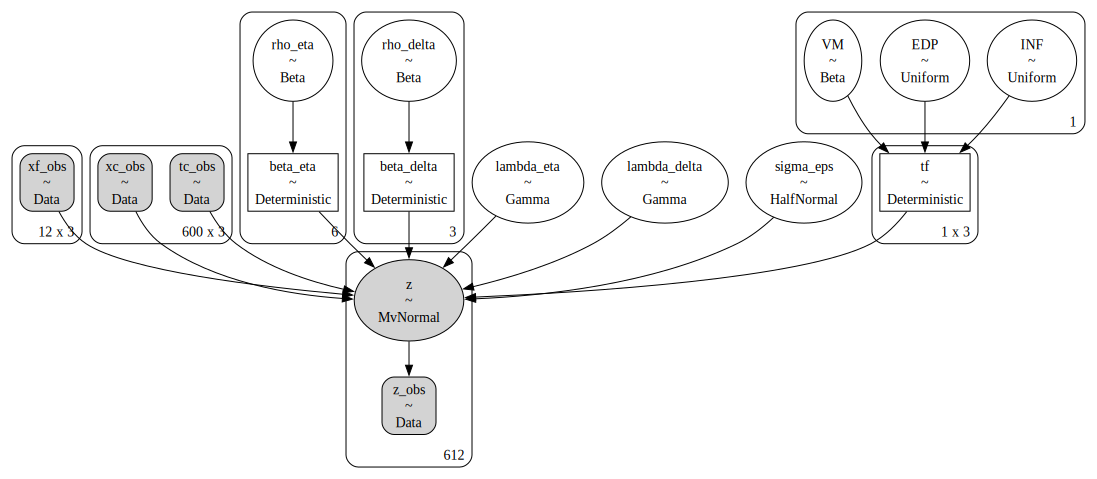

In [13]:
pm.model_to_graphviz(NI_model)

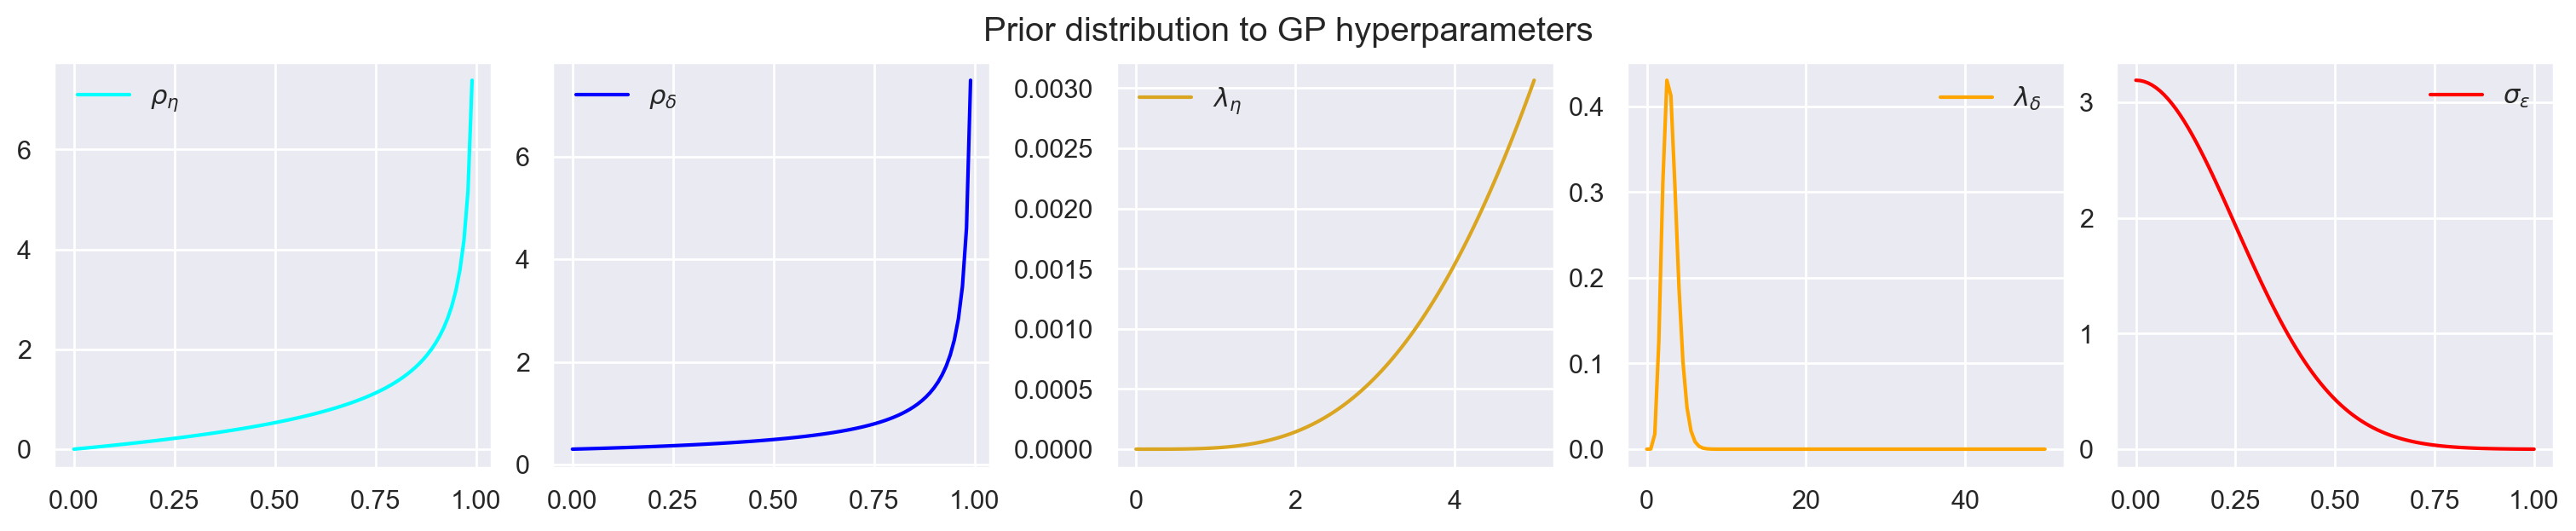

In [38]:
# **********BETA and GAMMA Distribution ********************

fig, axs = plt.subplots(1, 5, figsize = (15, 3))
fig.suptitle(r"Prior distribution to GP hyperparameters")

#define x-axis values
x_beta = np.linspace (0, 1, 100)
x_gamma_lambda_eta = np.linspace (0, 5, 100)
x_gamma_lambda_delta = np.linspace (0, 50, 100)
x_halfnorm_sigma_eps = np.linspace(0, 1, 100)

#create plot of Beta and Gamma distributions pof GP's hyperparameters
axs[0].plot(x_beta, sp.stats.beta.pdf(x_beta, a=2, b=0.5), color='cyan', label=r'$\rho_{\eta}$')
axs[0].legend()
axs[1].plot(x_beta, sp.stats.beta.pdf(x_beta, a=1, b=0.3), color='blue', label=r'$\rho_{\delta}$')
axs[1].legend()
axs[2].plot(x_gamma_lambda_eta, sp.stats.gamma.pdf(x_gamma_lambda_eta, a=5, scale=5), color='goldenrod', label=r'$\lambda_{\eta}$')
axs[2].legend()
axs[3].plot(x_gamma_lambda_delta, sp.stats.gamma.pdf(x_gamma_lambda_delta, a=10, scale=0.3), color='orange', label=r'$\lambda_{\delta}$')
axs[3].legend()
axs[4].plot(x_halfnorm_sigma_eps, sp.stats.halfnorm.pdf(x_halfnorm_sigma_eps, loc=0, scale=0.25), color='red', label=r'$\sigma_{\epsilon}$')
axs[4].legend()

#display plot
plt.show()

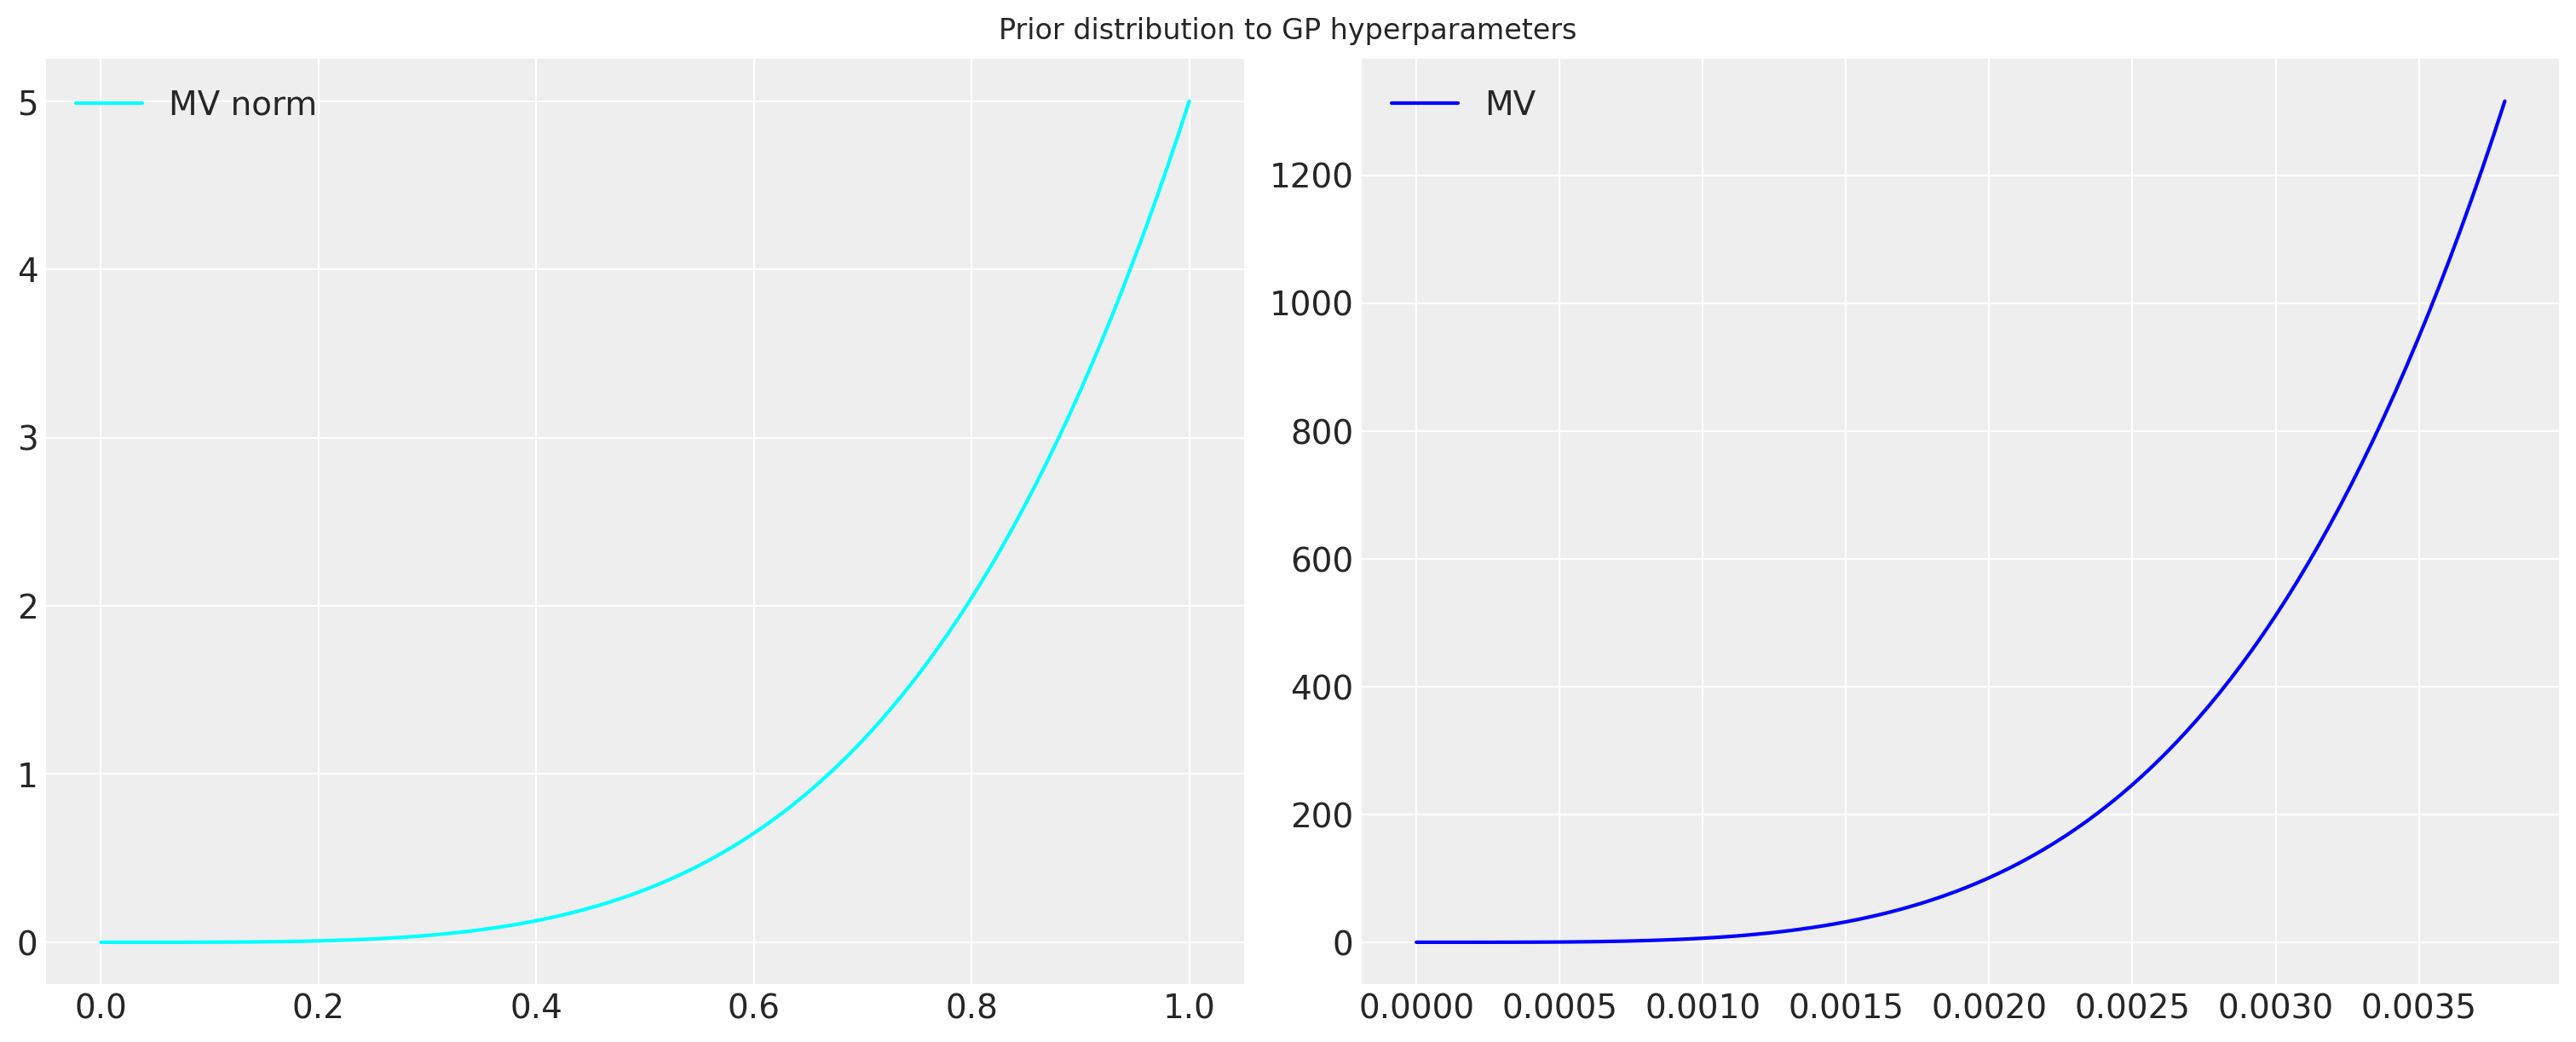

In [15]:
# **********BETA and GAMMA Distribution ********************

fig, axs = plt.subplots(1, 2, figsize = (15, 6))
fig.suptitle(r"Prior distribution to GP hyperparameters")

a = 0
b = 0.0038

#define x-axis values
x_beta = np.linspace (0, 1, 100)
x_beta_bis = np.linspace (a, b, 100)

#create plot of Beta and Gamma distributions pof GP's hyperparameters
axs[0].plot(x_beta, sp.stats.beta.pdf(x_beta, a=5, b=1), color='cyan', label='MV norm')
axs[0].legend()
axs[1].plot(x_beta_bis, 1/(b-a)*sp.stats.beta.pdf(x_beta, a=5, b=1), color='blue', label="MV")
axs[1].legend()

#display plot
plt.show()

In [16]:
with NI_model:
    idataNI = pm.sample(draws = n_draws, tune = n_tune, random_seed = rng, chains = chains, cores = cores, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [rho_eta, rho_delta, lambda_eta, lambda_delta, sigma_eps, INF, VM, EDP]


Output()

Sampling 8 chains for 2_000 tune and 2_000 draw iterations (16_000 + 16_000 draws total) took 411470 seconds.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### Trace des chaines de Markov et distributions à posteriori

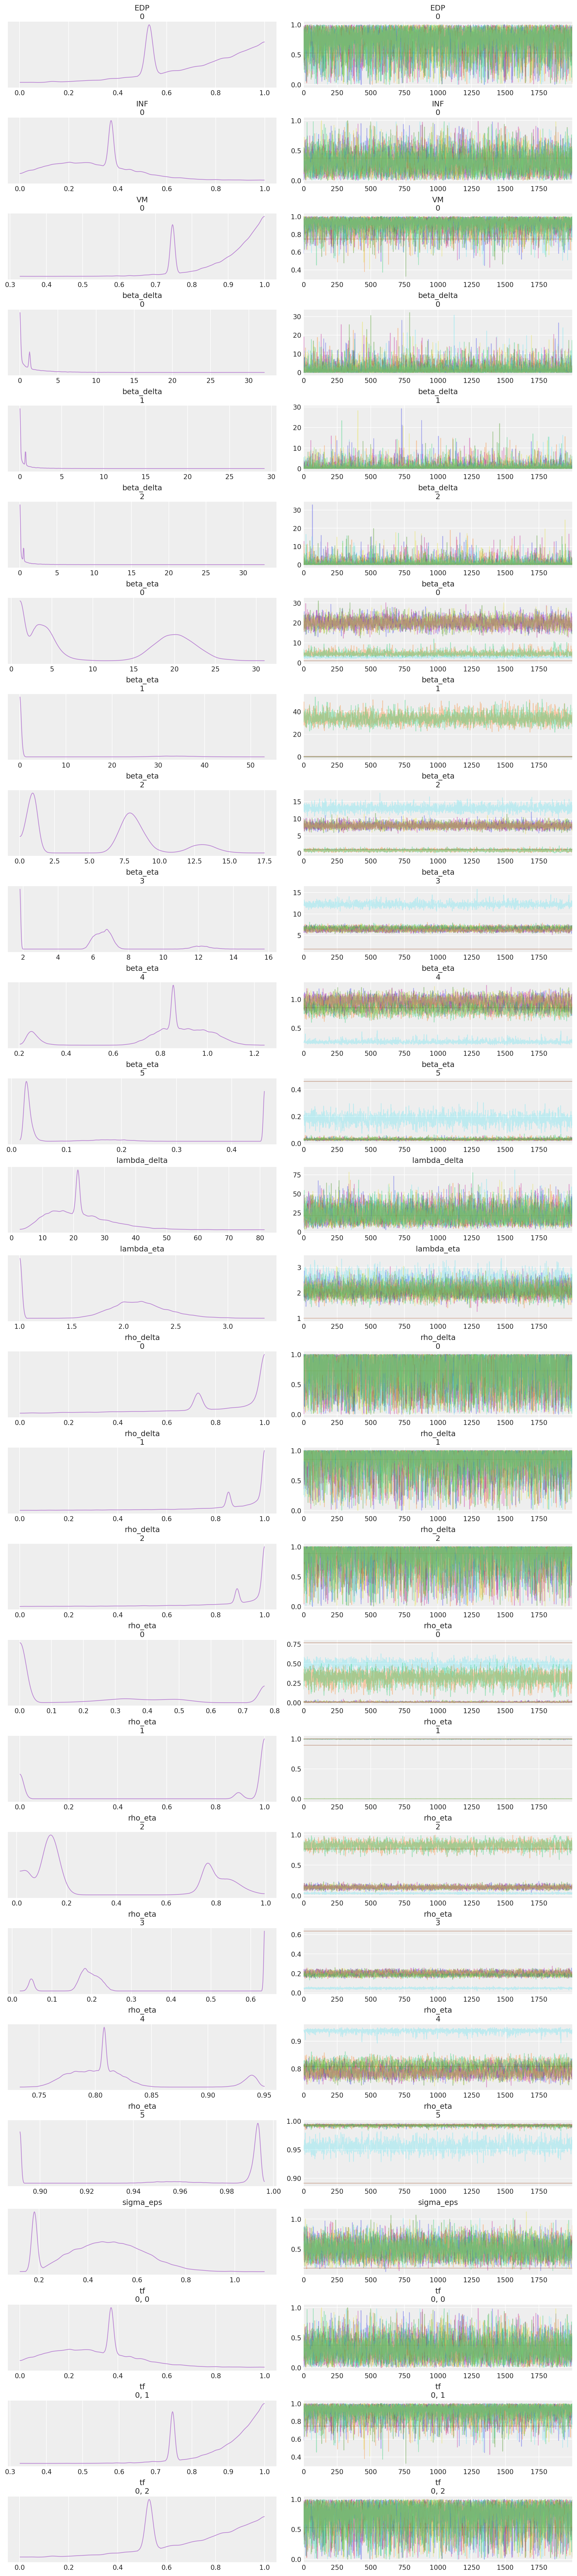

In [17]:
# Affichage des distributions à posteriori et des chaines de Markov pour chaque paramètre
az.plot_trace(idataNI, combined = True, compact = False);

#### Résumé des résultats

In [18]:
az.summary(idataNI, round_to = 2).drop(labels = ["mcse_mean", "mcse_sd", "ess_bulk", "ess_tail"], axis = 1)

mean     sd  hdi_3%  hdi_97%  r_hat
EDP[0]          0.71   0.23    0.30     1.00   1.05
INF[0]          0.31   0.17    0.00     0.58   1.02
VM[0]           0.90   0.09    0.75     1.00   1.16
beta_delta[0]   1.67   2.54    0.00     6.02   1.07
beta_delta[1]   0.87   1.63    0.00     3.30   1.03
beta_delta[2]   0.86   1.70    0.00     3.37   1.08
beta_eta[0]    11.74   8.66    1.05    23.02   2.24
beta_eta[1]     8.57  14.89    0.00    37.10   2.03
beta_eta[2]     5.96   4.33    0.13    13.15   2.40
beta_eta[3]     6.66   2.64    1.82    12.20   2.10
beta_eta[4]     0.82   0.23    0.23     1.07   1.89
beta_eta[5]     0.10   0.14    0.02     0.46   1.67
lambda_delta   21.86   9.62    5.89    40.05   1.27
lambda_eta      2.02   0.46    1.00     2.60   1.50
rho_delta[0]    0.74   0.26    0.22     1.00   1.07
rho_delta[1]    0.85   0.19    0.44     1.00   1.03
rho_delta[2]    0.85   0.20    0.43     1.00   1.09
rho_eta[0]      0.24   0.27    0.00     0.77   2.24
rho_eta[1]      0.74   0.43    0.00     1.00   2.03
rho_eta[2]      0.38   0.34    0.02     0.88   2.40
rho_eta[3]      0.23   0.16    0.05     0.63   2.10
rho_eta[4]      0.82   0.05    0.77     0.94   1.89
rho_eta[5]      0.98   0.03    0.89     0.99   1.67
sigma_eps       0.46   0.17    0.18     0.72   1.26
tf[0, 0]        0.31   0.17    0.00     0.58   1.02
tf[0, 1]        0.90   0.09    0.75     1.00   1.16
tf[0, 2]        0.71   0.23    0.30     1.00   1.05

#### Remise à l'échelle des variables incertaines

In [19]:
tf_std_NI = pd.DataFrame(np.array(az.extract(idataNI, group = 'posterior', combined = True, var_names = "tf")).T.reshape((-1, 3)), columns = ['INF', 'MV', 'EPD'])

In [20]:
tf_NI = tf_std_NI*(tc_max-tc_min)+tc_min

#### Visualisation des distributions à posteriori des variables incertaines

In [21]:
n_points = 100

a = [tc_max.iloc[0]-tc_min.iloc[0], tc_max.iloc[1]-tc_min.iloc[1], tc_max.iloc[2]-tc_min.iloc[2]]
b = [tc_min.iloc[0], tc_min.iloc[1], tc_min.iloc[2]]

tt1 = np.linspace(tc_min.iloc[0], tc_max.iloc[0], n_points)
tt2 = np.linspace(tc_min.iloc[1], tc_max.iloc[1], n_points)
tt2_bis = np.linspace(0, 1, n_points)
tt3 = np.linspace(tc_min.iloc[2], tc_max.iloc[2], n_points)

pdf_NI = np.zeros((3, n_points))

pdf_NI[0,:] = sp.stats.uniform.pdf(tt1, loc = b[0], scale = a[0])
pdf_NI[1,:] = np.abs(1/(b[1]-a[1]))*sp.stats.beta.pdf(tt2_bis, a=5, b=1)
pdf_NI[2,:] = sp.stats.uniform.pdf(tt3, loc = b[2], scale = a[2])

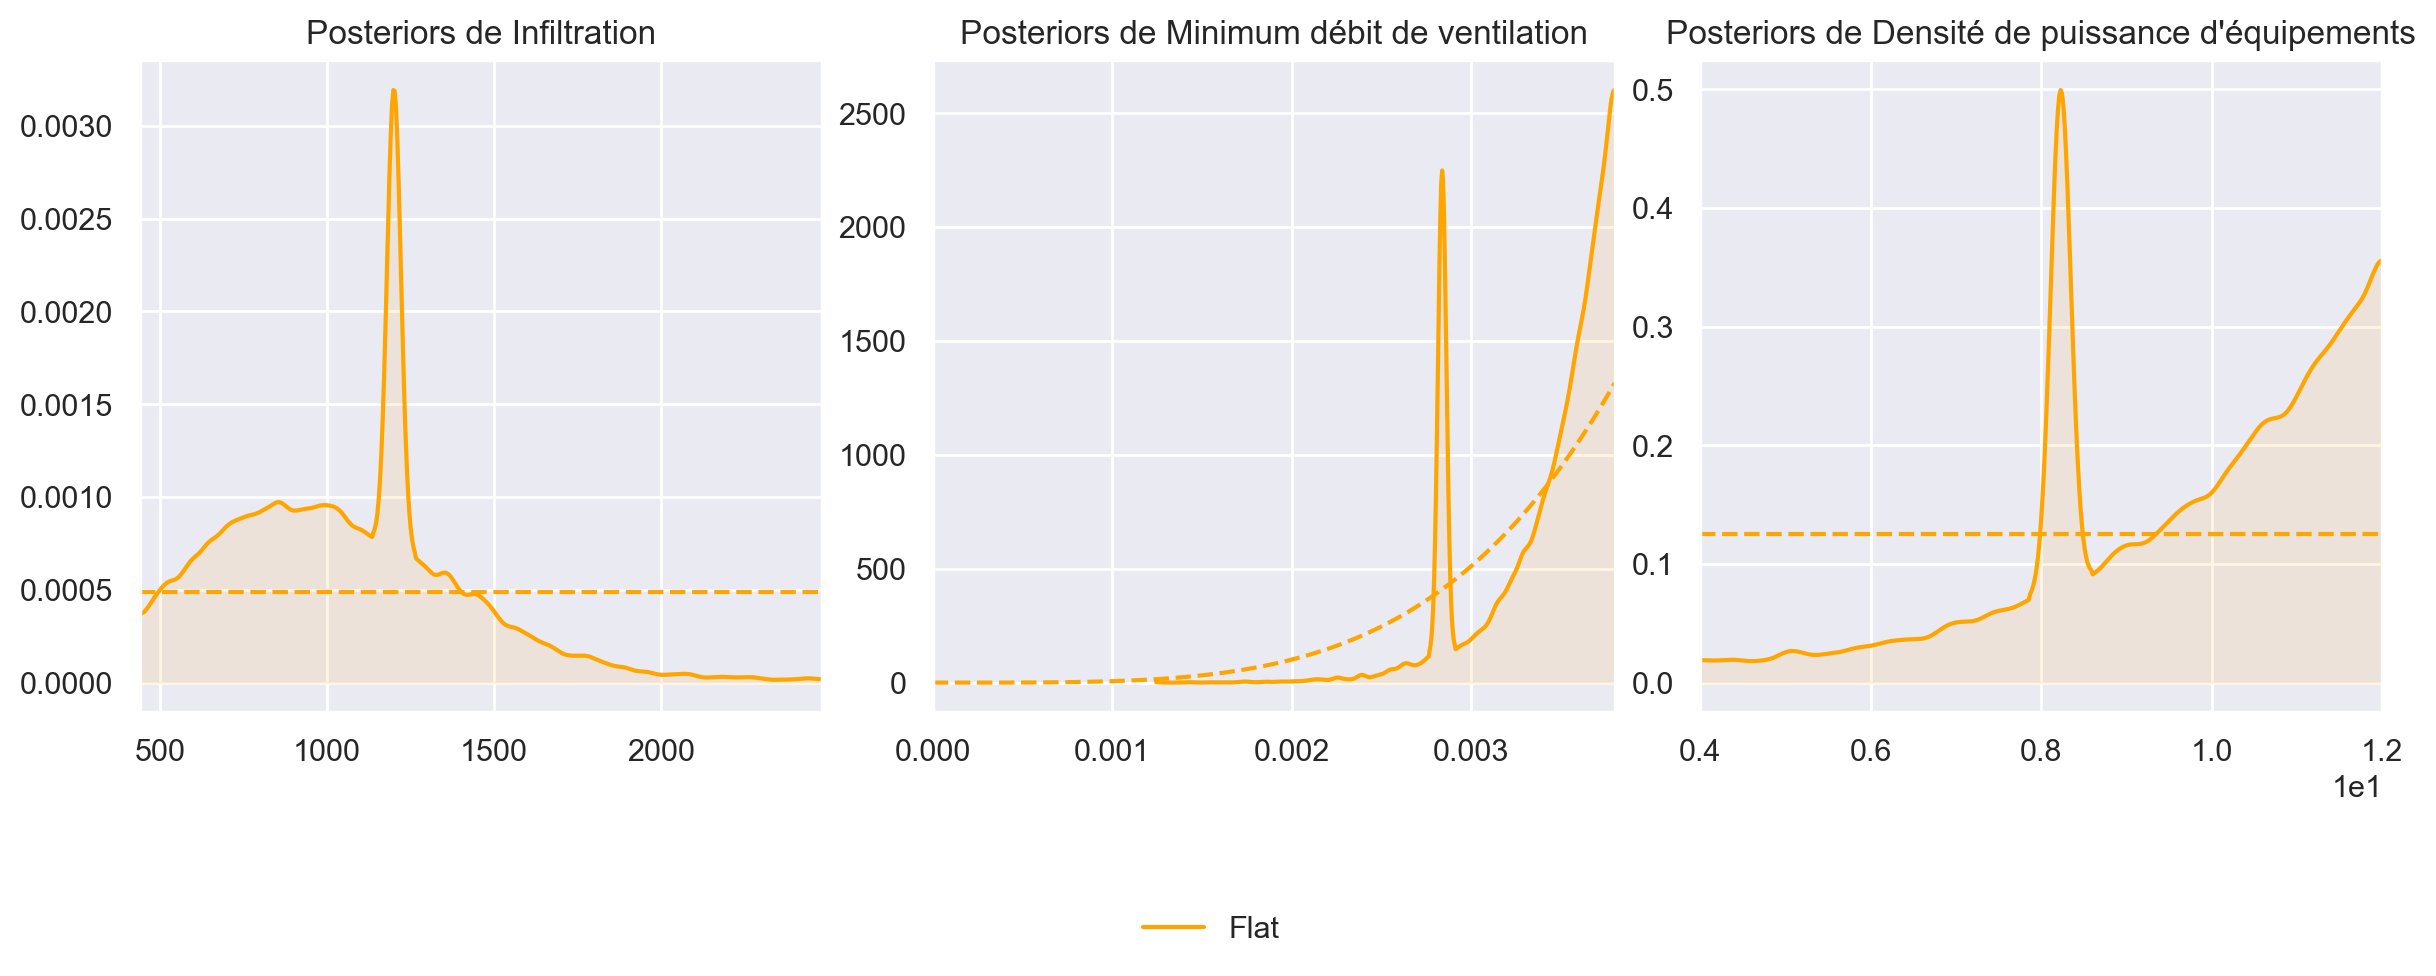

In [22]:
sns.set()

tc1_NI, dtc1_NI = az.kde(tf_NI["INF"])
tc2_NI, dtc2_NI = az.kde(tf_NI["MV"])
tc3_NI, dtc3_NI = az.kde(tf_NI["EPD"])

labels = ["Flat"]

# Tracé des distributions à posteriori
fig, axs = plt.subplots(1, 3, figsize = (12,4))


axs[0].plot(tc1_NI, dtc1_NI, color = "orange", label = labels[0]);
axs[0].plot(tt1, pdf_NI[0], color = "orange", linestyle = "dashed");
axs[0].fill_between(tc1_NI, dtc1_NI, 0, color = 'orange', alpha= 0.1);
axs[0].set_xlim(tc_min.iloc[0], tc_max.iloc[0]);
axs[0].set_title("Posteriors de Infiltration");

axs[1].plot(tc2_NI, dtc2_NI, color = "orange", label = labels[0]);
axs[1].plot(tt2, pdf_NI[1], color = "orange", linestyle = "dashed");
axs[1].fill_between(tc2_NI, dtc2_NI, 0, color = 'orange', alpha= 0.1);
axs[1].set_xlim(tc_min.iloc[1], tc_max.iloc[1]);
axs[1].set_title("Posteriors de Minimum débit de ventilation");

axs[2].plot(tc3_NI, dtc3_NI, color = "orange", label = labels[0]);
axs[2].plot(tt3, pdf_NI[2], color = "orange", linestyle = "dashed");
axs[2].fill_between(tc3_NI, dtc3_NI, 0, color = 'orange', alpha= 0.1);
axs[2].set_xlim(tc_min.iloc[2], tc_max.iloc[2]);
axs[2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs[2].set_title("Posteriors de Densité de puissance d'équipements");

lines_labels = [axs[0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.2))

## Prédictions du modèle à posteriori

On note $y^*$ les valeurs que l'on souhaite prédire aux points $x^*$. Dans ce qui suit, on note $u=(x,t)$ l'ensemble des paramètres du modèle, puis on fait la distinction entre $u_f$, $u_{\eta}$ et $u^*$ qui correspondent resepctivement à $(x_f, t_f)$, $(x_c, t_c)$ et enfin $(x^*, t_f)$. La loi jointe de $z$ et $y^*$ peut donc s'écrire:

$$\begin{bmatrix} y \\ \eta \\ y^* \end{bmatrix} \sim\mathcal{N}\biggl(\begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} K_{\eta}(u_f,u_f)+K_{\delta}(x_f,x_f)+\sigma^2I & K_{\eta}(u_f,u_{\eta}) & K_{\eta}(u_f,u^*)+K_{\delta}(x_f,x^*) \\ K_{\eta}(u_{\eta},u_f) & K_{\eta}(u_{\eta},u_{\eta}) & K_{\eta}(u_{\eta},u^*) \\ K_{\eta}(u^*,u_f)+K_{\delta}(x^*,x_f) & K_{\eta}(u^*,u_{\eta}) & K_{\eta}(u^*,u^*)+K_{\delta}(x^*,x^*)+\sigma^2I \end{bmatrix}\biggr)$$

Les hypothèses d'indépendances entre $\eta$, $\delta$ et $\epsilon$ sont nécessaires pour obtenir la loi jointe ci-dessus.
Afin de faire la prédiction de $y^*$, il faut donc prendre la conditionnel de $y^*$ sachant $z$. On note $\Sigma_z$ la matrice de covariance de $z$, qui correspond au bloc supérieur gauche de la covariance de la loi jointe.

$$\Sigma_z = \begin{bmatrix} K_{\eta}(u_f,u_f)+K_{\delta}(x_f,x_f)+\sigma^2I & K_{\eta}(u_f,u_{\eta}) \\ K_{\eta}(u_{\eta},u_f) & K_{\eta}(u_{\eta},u_{\eta})\end{bmatrix}.$$

On a ainsi,

$$ y^*|y,\eta \sim\mathcal{N}(\mu^*, \Sigma^*),$$

avec

$$\mu^*= \begin{bmatrix}K_{\eta}(u^*,u_f)+K_{\delta}(x^*,x_f) & K_{\eta}(u^*,u_{\eta})\end{bmatrix} \Sigma_z^{-1}z,$$

$$\Sigma^*= \begin{bmatrix}K_{\eta}(u^*,u^*)+K_{\delta}(x^*,x^*)+\sigma^2I \end{bmatrix}-\begin{bmatrix}K_{\eta}(u^*,u_f)+K_{\delta}(x^*,x_f) & K_{\eta}(u^*,u_{\eta})\end{bmatrix}\Sigma_z^{-1}\begin{bmatrix}K_{\eta}(u_f,u^*)+K_{\delta}(x_f,x^*) \\ K_{\eta}(u_{\eta},u^*)\end{bmatrix}.$$

Le même raisonnement peut également être appliqué afin d'obtenir les prédictions individuelles de $\eta$ et $\delta$ ou même de $\eta+\delta$, cependant, la loi jointe dans chacun de ces cas sera donc quelque peu différente. Etant donné que l'on utilise à la fois les données simulées et observées, les matrices peuvent être de très grandes tailles, ce qui peut donc poser quelques soucis numériques étant donnée qu'une inversion est nécessaire.

La loi jointe de $z$ et $\eta^*+\delta^*$ s'écrit:

$$\begin{bmatrix} y \\ \eta \\ \eta^*+\delta^* \end{bmatrix} \sim\mathcal{N}\biggl(\begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} K_{\eta}(u_f,u_f)+K_{\delta}(x_f,x_f)+\sigma^2I & K_{\eta}(u_f,u_{\eta}) & K_{\eta}(u_f,u^*)+K_{\delta}(x_f,x^*) \\ K_{\eta}(u_{\eta},u_f) & K_{\eta}(u_{\eta},u_{\eta}) & K_{\eta}(u_{\eta},u^*) \\ K_{\eta}(u^*,u_f)+K_{\delta}(x^*,x_f) & K_{\eta}(u^*,u_{\eta}) & K_{\eta}(u^*,u^*)+K_{\delta}(x^*,x^*) \end{bmatrix}\biggr)$$

On a ainsi

$$ \eta^*+\delta^*|y,\eta \sim\mathcal{N}(\mu^*, \Sigma^*),$$

avec

$$\mu^*= \begin{bmatrix}K_{\eta}(u^*,u_f)+K_{\delta}(x^*,x_f) & K_{\eta}(u^*,u_{\eta})\end{bmatrix} \Sigma_z^{-1}z,$$

$$\Sigma^*= \begin{bmatrix}K_{\eta}(u^*,u^*)+K_{\delta}(x^*,x^*) \end{bmatrix}-\begin{bmatrix}K_{\eta}(u^*,u_f)+K_{\delta}(x^*,x_f) & K_{\eta}(u^*,u_{\eta})\end{bmatrix}\Sigma_z^{-1}\begin{bmatrix}K_{\eta}(u_f,u^*)+K_{\delta}(x_f,x^*) \\ K_{\eta}(u_{\eta},u^*)\end{bmatrix}.$$

La loi jointe de $z$ et $\eta^*$ s'écrit:

$$\begin{bmatrix} y \\ \eta \\ \eta^* \end{bmatrix} \sim\mathcal{N}\biggl(\begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}, \begin{bmatrix} K_{\eta}(u_f,u_f)+K_{\delta}(x_f,x_f)+\sigma^2I & K_{\eta}(u_f,u_{\eta}) & K_{\eta}(u_f,u^*) \\ K_{\eta}(u_{\eta},u_f) & K_{\eta}(u_{\eta},u_{\eta}) & K_{\eta}(u_{\eta},u^*) \\ K_{\eta}(u^*,u_f) & K_{\eta}(u^*,u_{\eta}) & K_{\eta}(u^*,u^*) \end{bmatrix}\biggr)$$

On a ainsi

$$ \eta^*|y,\eta \sim\mathcal{N}(\mu^*, \Sigma^*),$$

avec

$$\mu^*= \begin{bmatrix}K_{\eta}(u^*,u) & K_{\eta}(u^*,u_{\eta})\end{bmatrix} \Sigma_z^{-1}z,$$

$$\Sigma^*= \begin{bmatrix}K_{\eta}(u^*,u^*) \end{bmatrix}-\begin{bmatrix}K_{\eta}(u^*,u_f) & K_{\eta}(u^*,u_{\eta})\end{bmatrix}\Sigma_z^{-1}\begin{bmatrix}K_{\eta}(u_f,u^*) \\ K_{\eta}(u_{\eta},u^*)\end{bmatrix}.$$

Enfin, pour obtenir la prédiction de $\delta^*$ conditionnellement à $z$, soit le même raisonnement peut être appliqué pour la calculer, soit on fait la différence entre $\eta^*+\delta^*$ et $\eta^*$.

In [23]:
# Fonction permettant d'extraire les posteriors pour chaque paramètres et hyper-paramètres 
def extract_idata(idata):

    # Extraction des posteriors
    tf = az.extract(idata, var_names = ["tf"], combined = True).values.T.reshape((-1, 3))
    beta_eta = az.extract(idata, var_names = ["beta_eta"], combined = True).values.T
    beta_delta = az.extract(idata, var_names = ["beta_delta"], combined = True).values.T
    lambda_eta = az.extract(idata, var_names = ["lambda_eta"], combined = True).values.reshape((n_draws*chains))
    lambda_delta = az.extract(idata, var_names = ["lambda_delta"], combined = True).values.reshape((n_draws*chains))
    sigma_eps = az.extract(idata, var_names = ["sigma_eps"], combined = True).values.reshape((n_draws*chains))

    n = len(tf)
    posteriors = []

    for i in range(n):
        posteriors.append({"tf": tf[i], "beta_eta": beta_eta[i], "beta_delta": beta_delta[i], "lambda_eta": lambda_eta[i], 
                  "lambda_delta": lambda_delta[i], "lambda_eps": 1/sigma_eps[i]**2})
                          
    return posteriors

### Fonctions permettant les prédictions

In [24]:
partial_y_pred = partial(Predictions.y_pred, x_star = np.array(x_star_std), xf = np.array(xf_std), 
                                 xc = np.array(xc_std), tc = np.array(tc_std), z = z)

partial_eta_delta_pred = partial(Predictions.eta_delta_pred, x_star = np.array(x_star_std), xf = np.array(xf_std), 
                                 xc = np.array(xc_std), tc = np.array(tc_std), z = z)

partial_eta_pred = partial(Predictions.eta_pred, x_star = np.array(x_star_std), xf = np.array(xf_std), 
                                 xc = np.array(xc_std), tc = np.array(tc_std), z = z)

partial_delta_pred = partial(Predictions.delta_pred, x_star = np.array(x_star_std), xf = np.array(xf_std), 
                                 xc = np.array(xc_std), tc = np.array(tc_std), z = z) 

def y_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        y_star_std = pool.map(partial_y_pred, (posteriors)) 

        return y_star_std

def eta_delta_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        eta_delta_star_std = pool.map(partial_eta_delta_pred, (posteriors)) 

        return eta_delta_star_std

def eta_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        eta_star_std = pool.map(partial_eta_pred, (posteriors)) 

        return eta_star_std

def delta_pred(posteriors, num_processors):
    if __name__ == "__main__":
        
        # Initialisation de la parallélisation
        pool = Pool(processes = num_processors)
    
        # Prédictions de eta+delta aux points x_star
        delta_star_std = pool.map(partial_delta_pred, (posteriors)) 

        return delta_star_std

In [25]:
posteriors_NI = extract_idata(idataNI)

num_processors = 16

### Prédictions de $y$

In [26]:
y_pred_NI = np.array(y_pred(posteriors_NI, num_processors))

# Remise à l'échelle des prédictions
y_pred_NI =  y_pred_NI * eta_sd + eta_mean

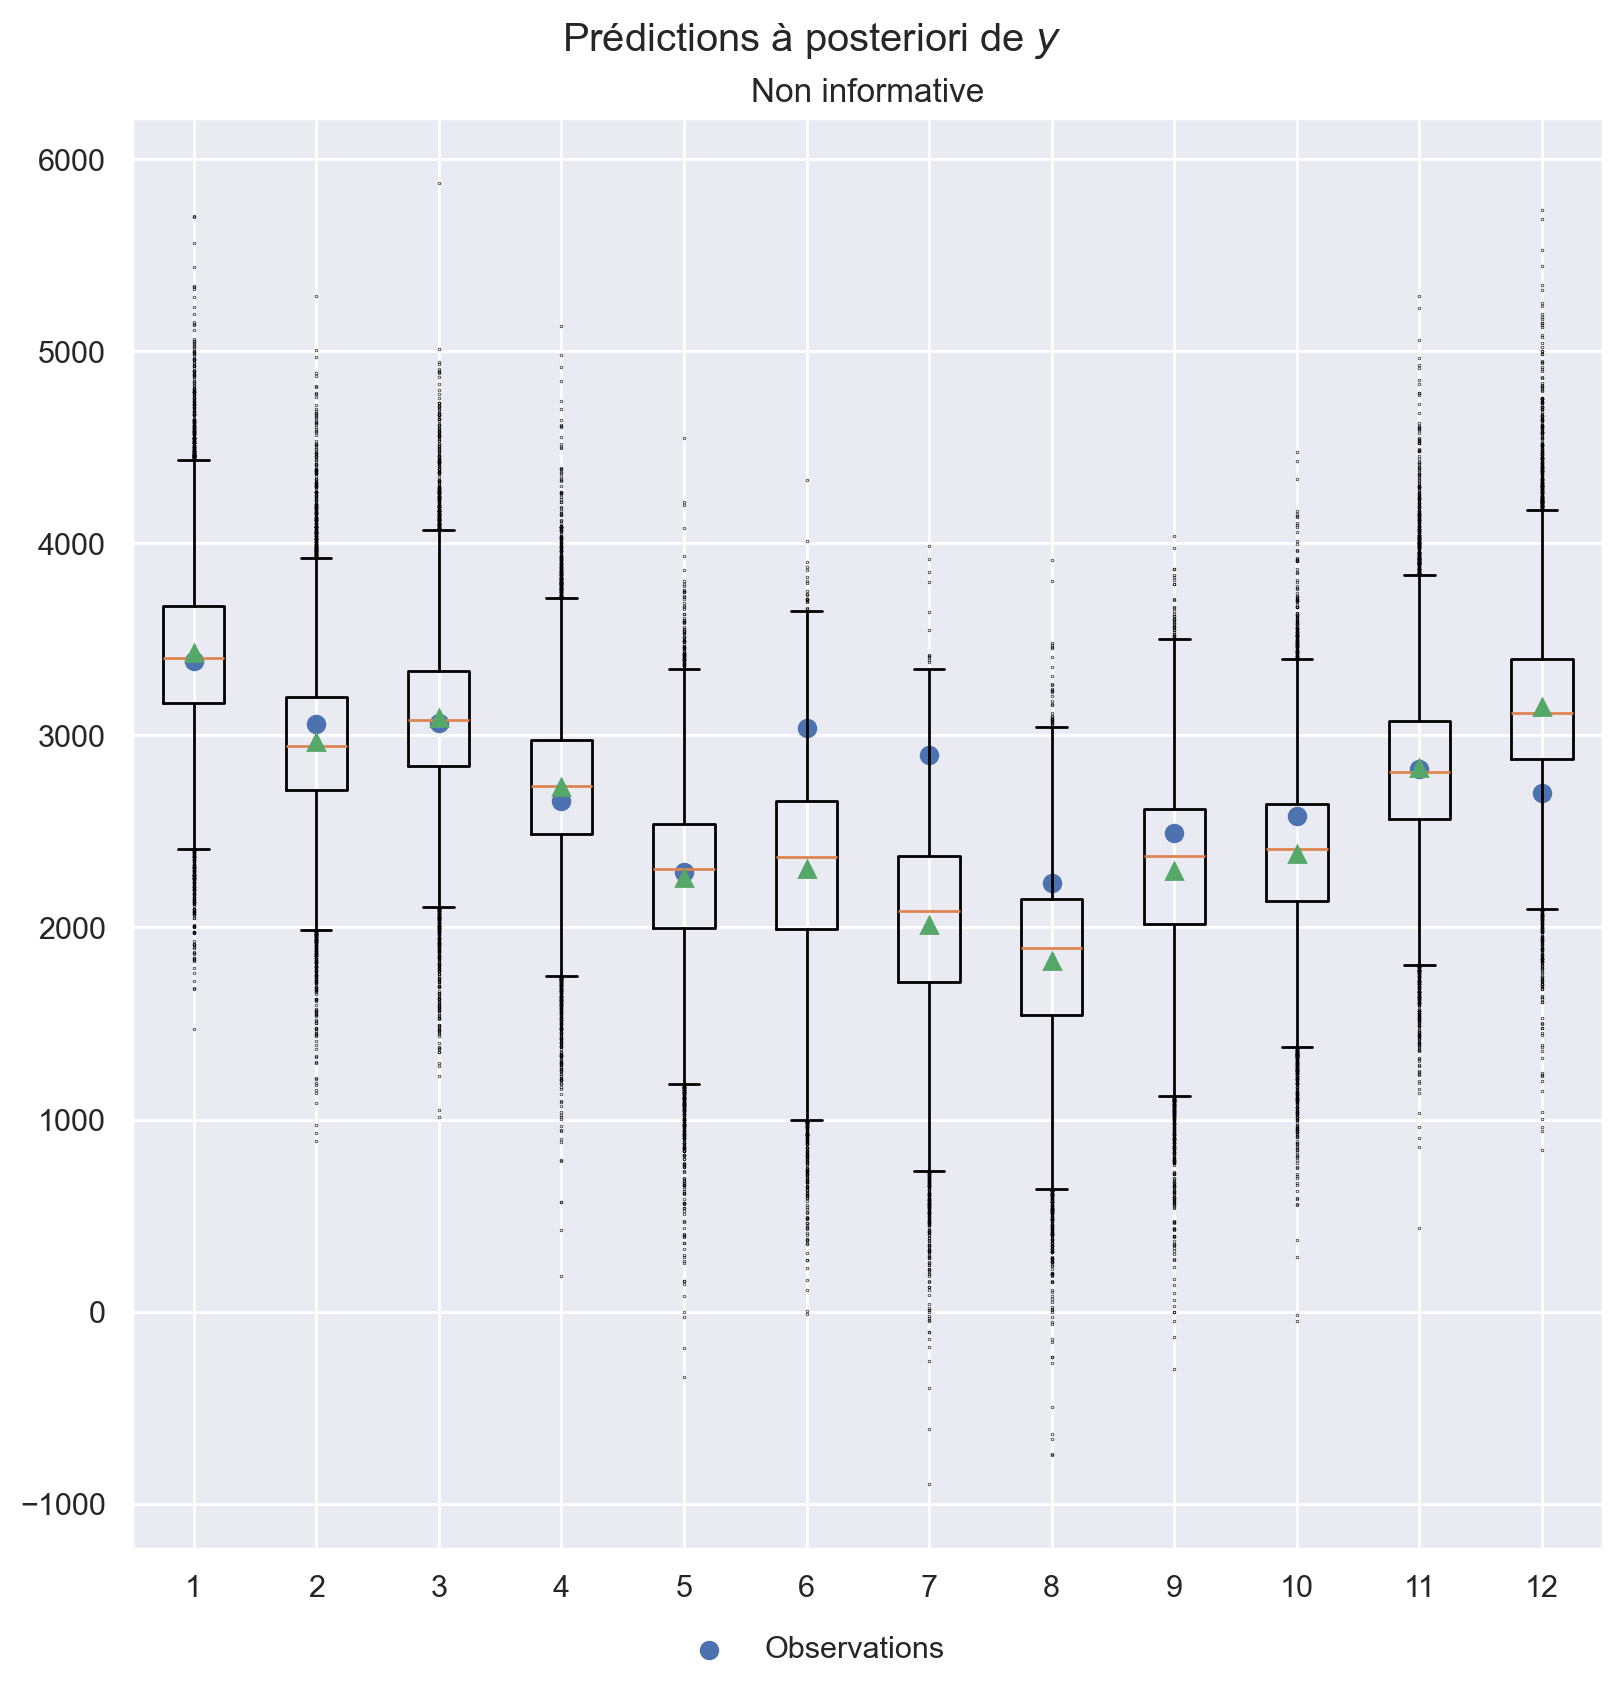

In [27]:
# Prédictions pour chaque prior

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

fig.suptitle(r"Prédictions à posteriori de $y$")

ax.boxplot(y_pred_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2), showmeans=True);
ax.scatter(range(1, n+1), y, label = "Observations");
ax.set_title("Non informative");

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.05));

plt.show()

### Evaluation du modèle avec les critères ASHRAE

Selon la guidelines ASHRAE, des valeurs de $CVRMSE<0.15$ et $NMBE<0.05$ indique que le modèle est bien calibré.

$$CVRMSE = \frac{\sqrt{\frac{\sum_{i=1}^n (y_i-\hat{y_i})^2}{n-1}}}{\bar{y}}$$

$$NMBE = \frac{|\sum_{i=1}^n (y_i-\hat{y_i})|}{(n-1)\bar{y}}$$

In [28]:
# Métriques d'évaluation du modèle calibré

def CVRMSE(y, yhat):
    return np.sqrt(np.sum((y-yhat)**2)/(n-1))/y.mean()

def NMBE(y, yhat):
    return np.abs(np.sum((y-yhat)))/((n-1)*y.mean())

In [29]:
CVRMSE_NI = CVRMSE(y, y_pred_NI.mean(axis = 0))

NMBE_NI = NMBE(y, y_pred_NI.mean(axis = 0))


df = pd.DataFrame([[CVRMSE_NI],[NMBE_NI]], index = ["CVRMSE", "NMBE"], columns = ["Non informative"])
df

Non informative
CVRMSE         0.145376
NMBE           0.064406

### Prédictions de $\eta+\delta$

In [30]:
eta_delta_pred_NI = np.array(eta_delta_pred(posteriors_NI, num_processors))

# Remise à l'échelle des prédictions
eta_delta_NI =  eta_delta_pred_NI*eta_sd+eta_mean

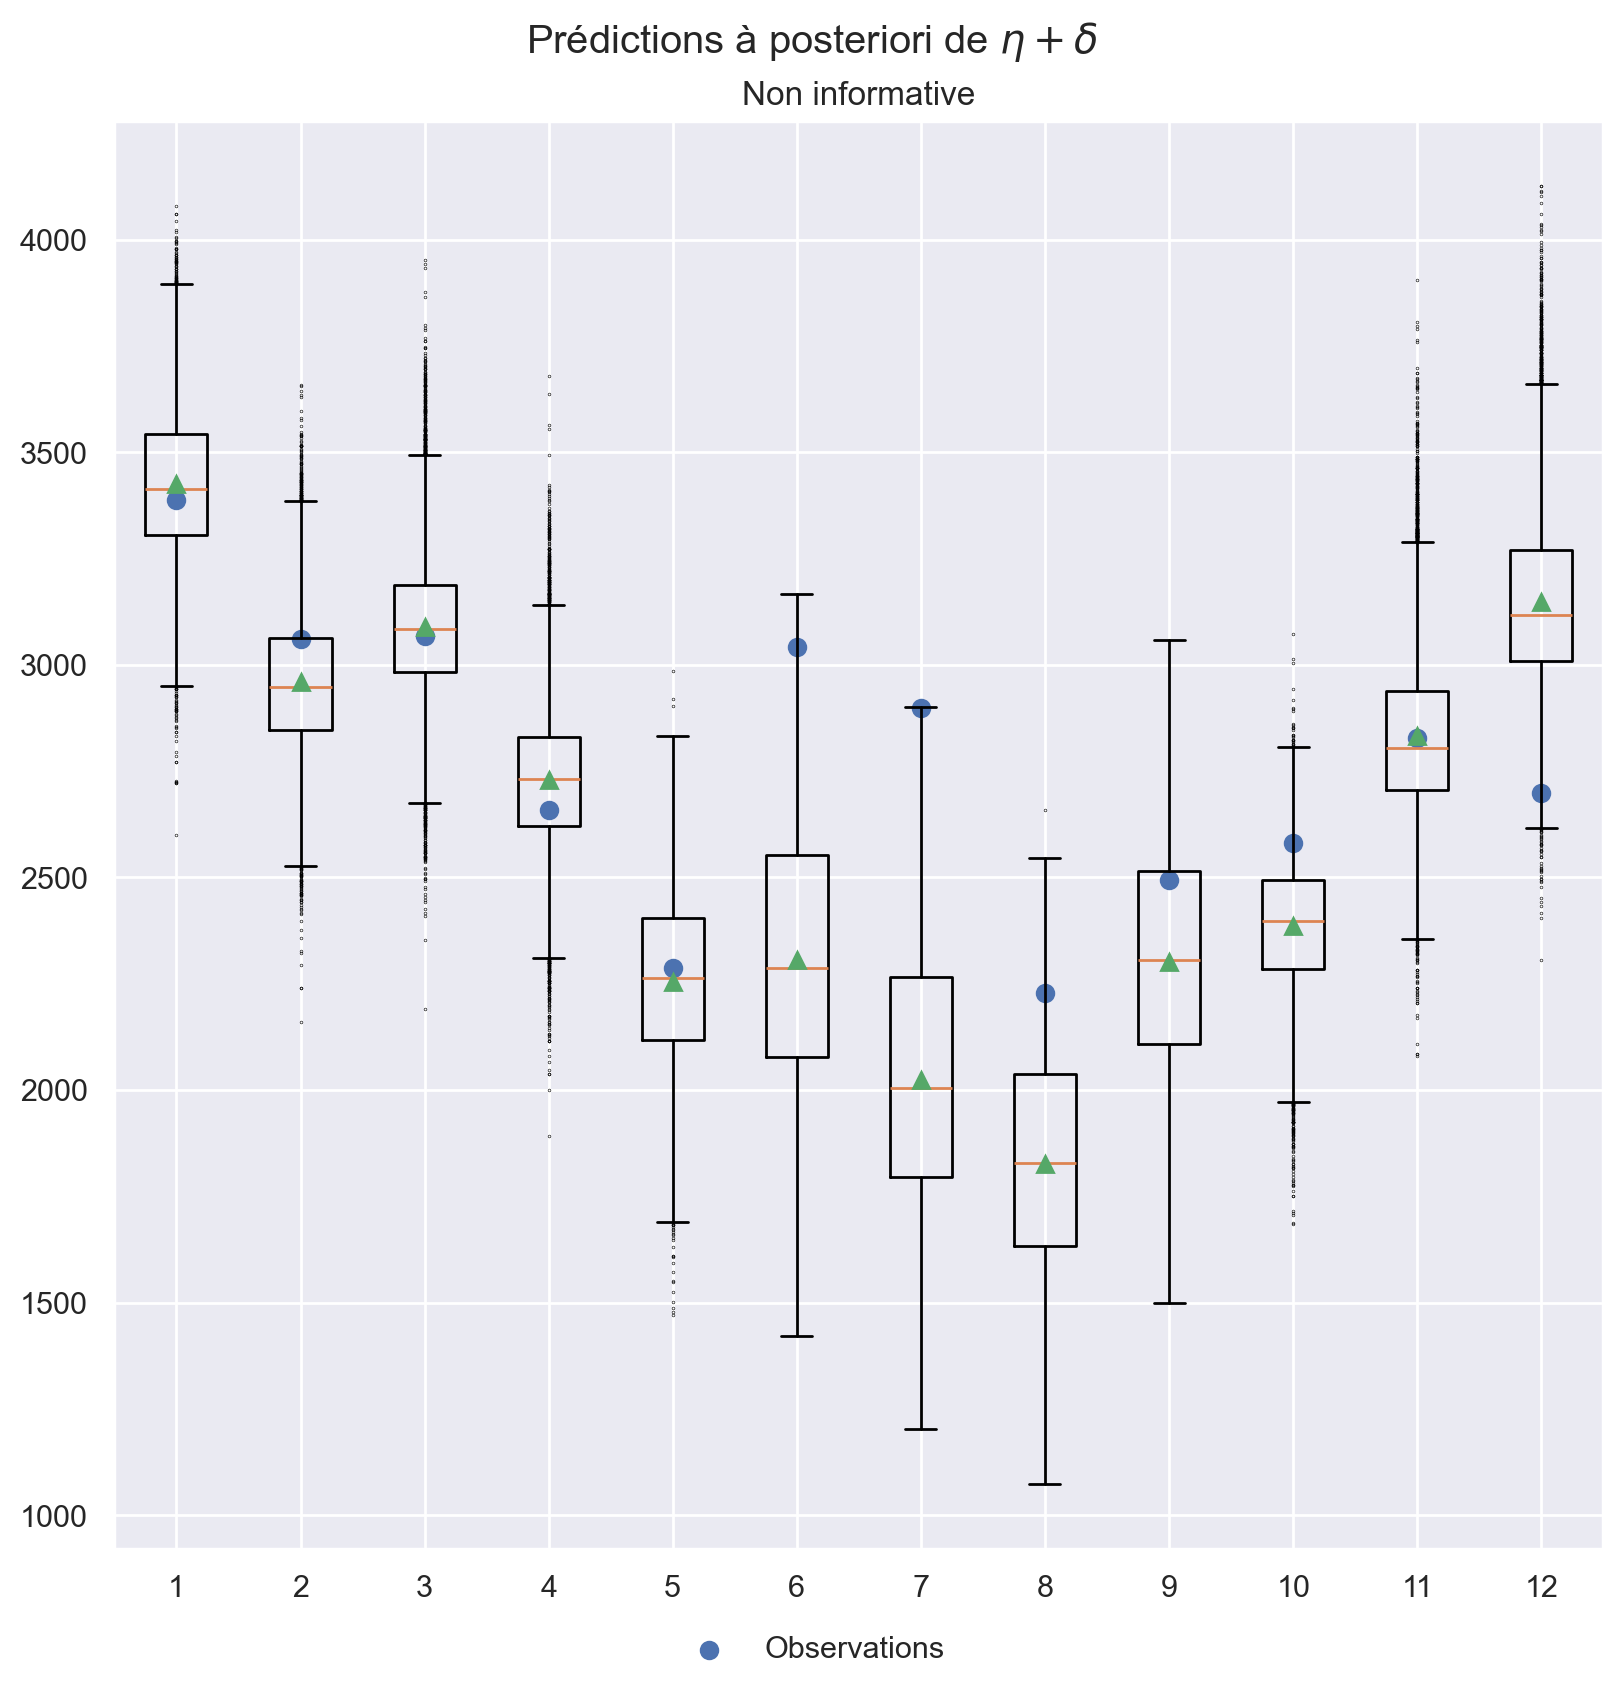

In [31]:
# Prédictions pour chaque prior

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

fig.suptitle(r"Prédictions à posteriori de $\eta+\delta$")

ax.boxplot(eta_delta_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2), showmeans=True);
ax.scatter(range(1, n+1), y, label = "Observations");
ax.set_title("Non informative");

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.05));

plt.show()

### Prédictions de $\eta$

In [32]:
eta_pred_std_NI = np.array(eta_pred(posteriors_NI, num_processors))

# Remise à l'échelle des prédictions
eta_pred_NI =  eta_pred_std_NI*eta_sd+eta_mean

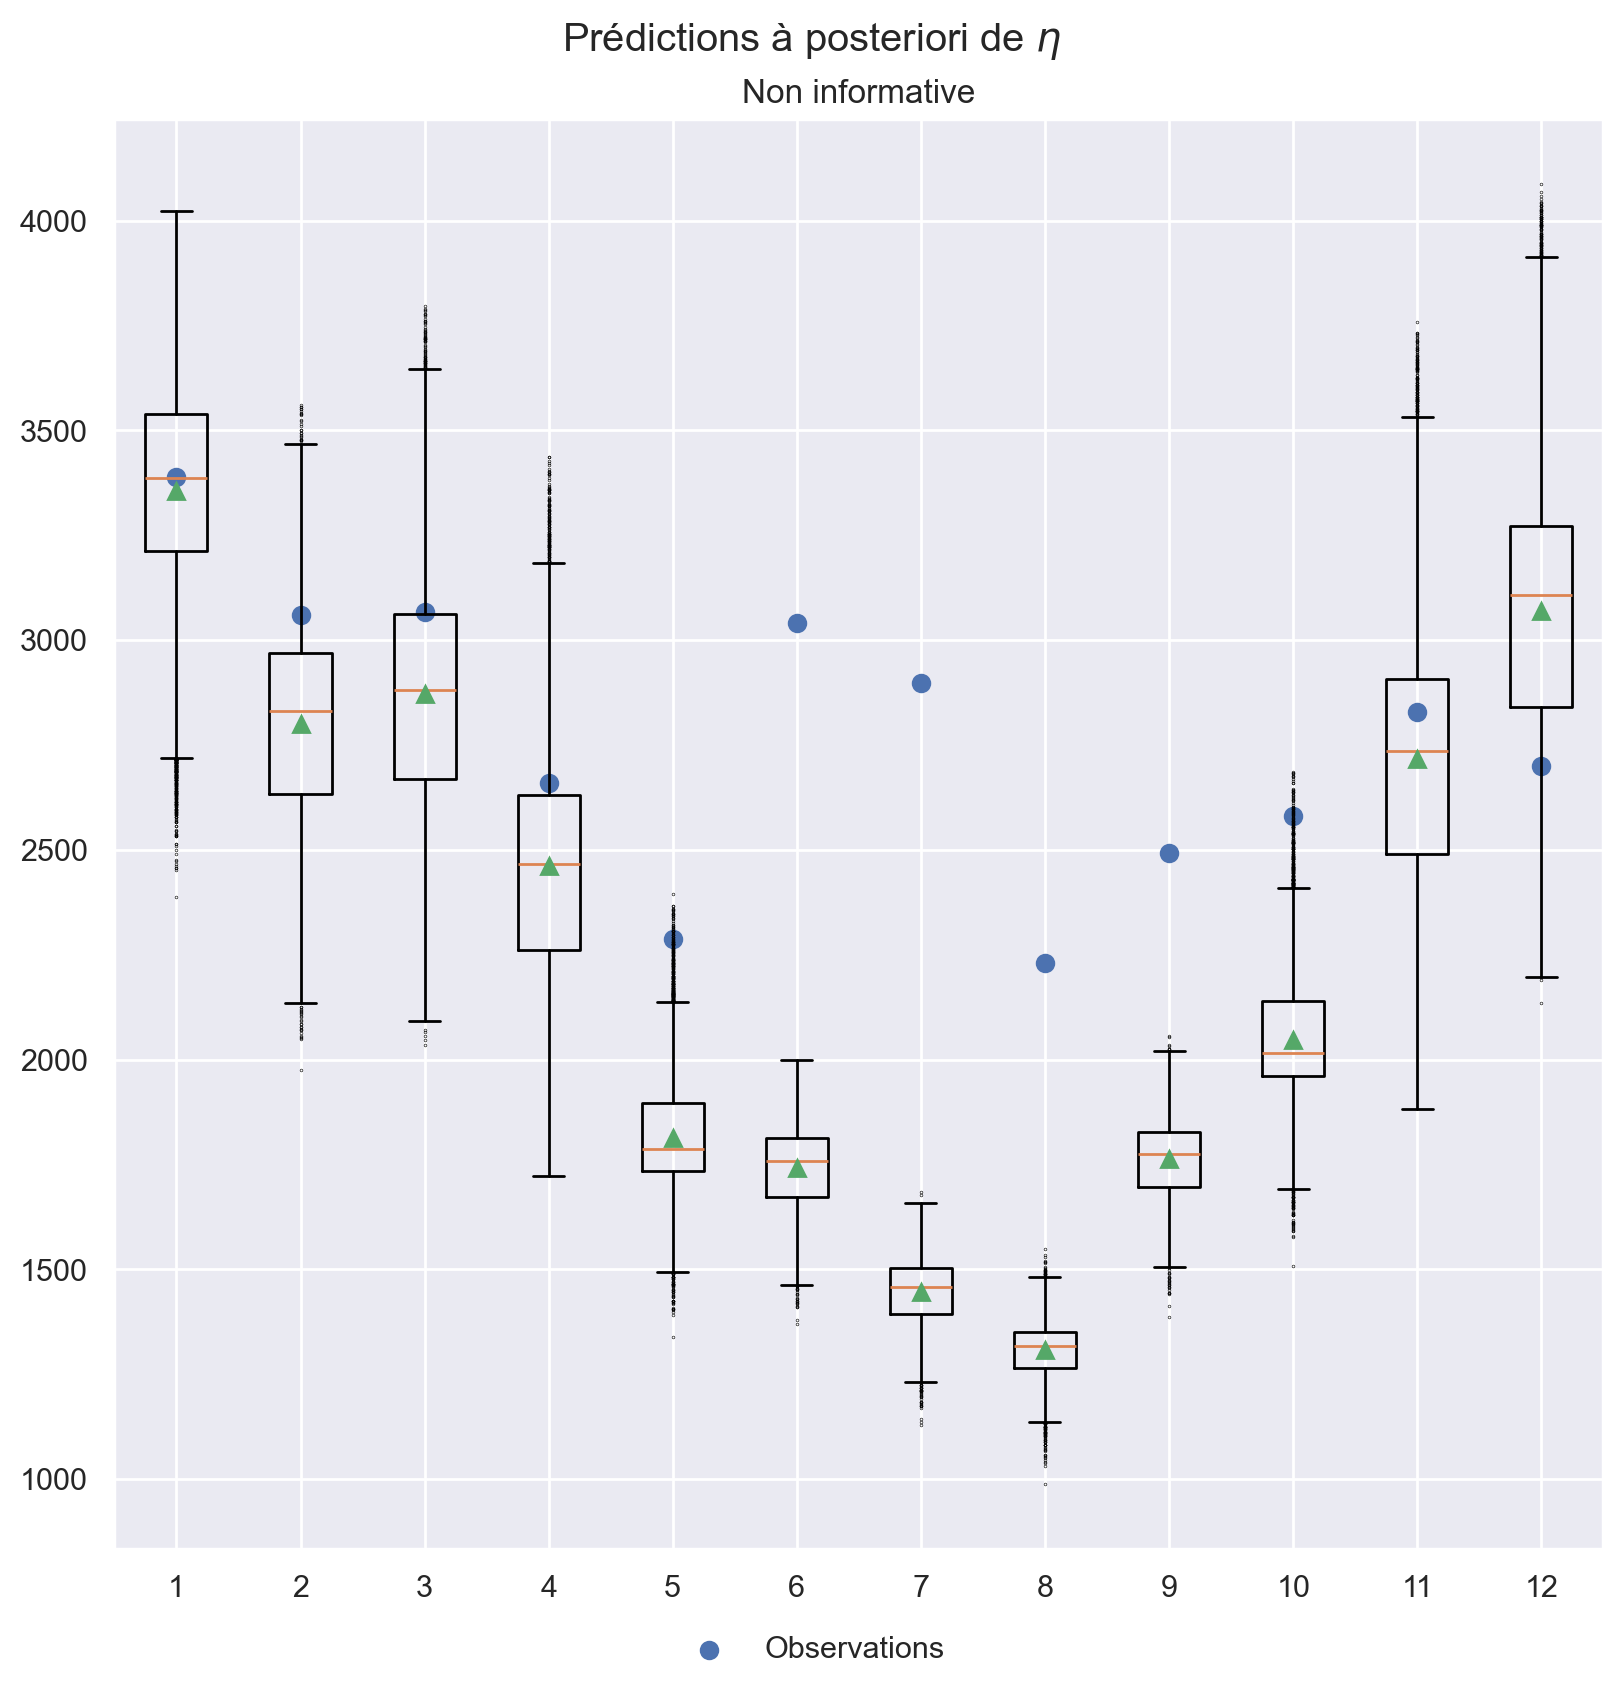

In [33]:
# Prédictions pour chaque prior

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

fig.suptitle(r"Prédictions à posteriori de $\eta$")

ax.boxplot(eta_pred_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2), showmeans=True);
ax.scatter(range(1, n+1), y, label = "Observations");
ax.set_title("Non informative");

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.05));

plt.show()

### Prédictions de $\delta$

In [34]:
delta_pred_std_NI = np.array(delta_pred(posteriors_NI, num_processors))

# Remise à l'échelle des prédictions
delta_pred_NI =  delta_pred_std_NI*eta_sd

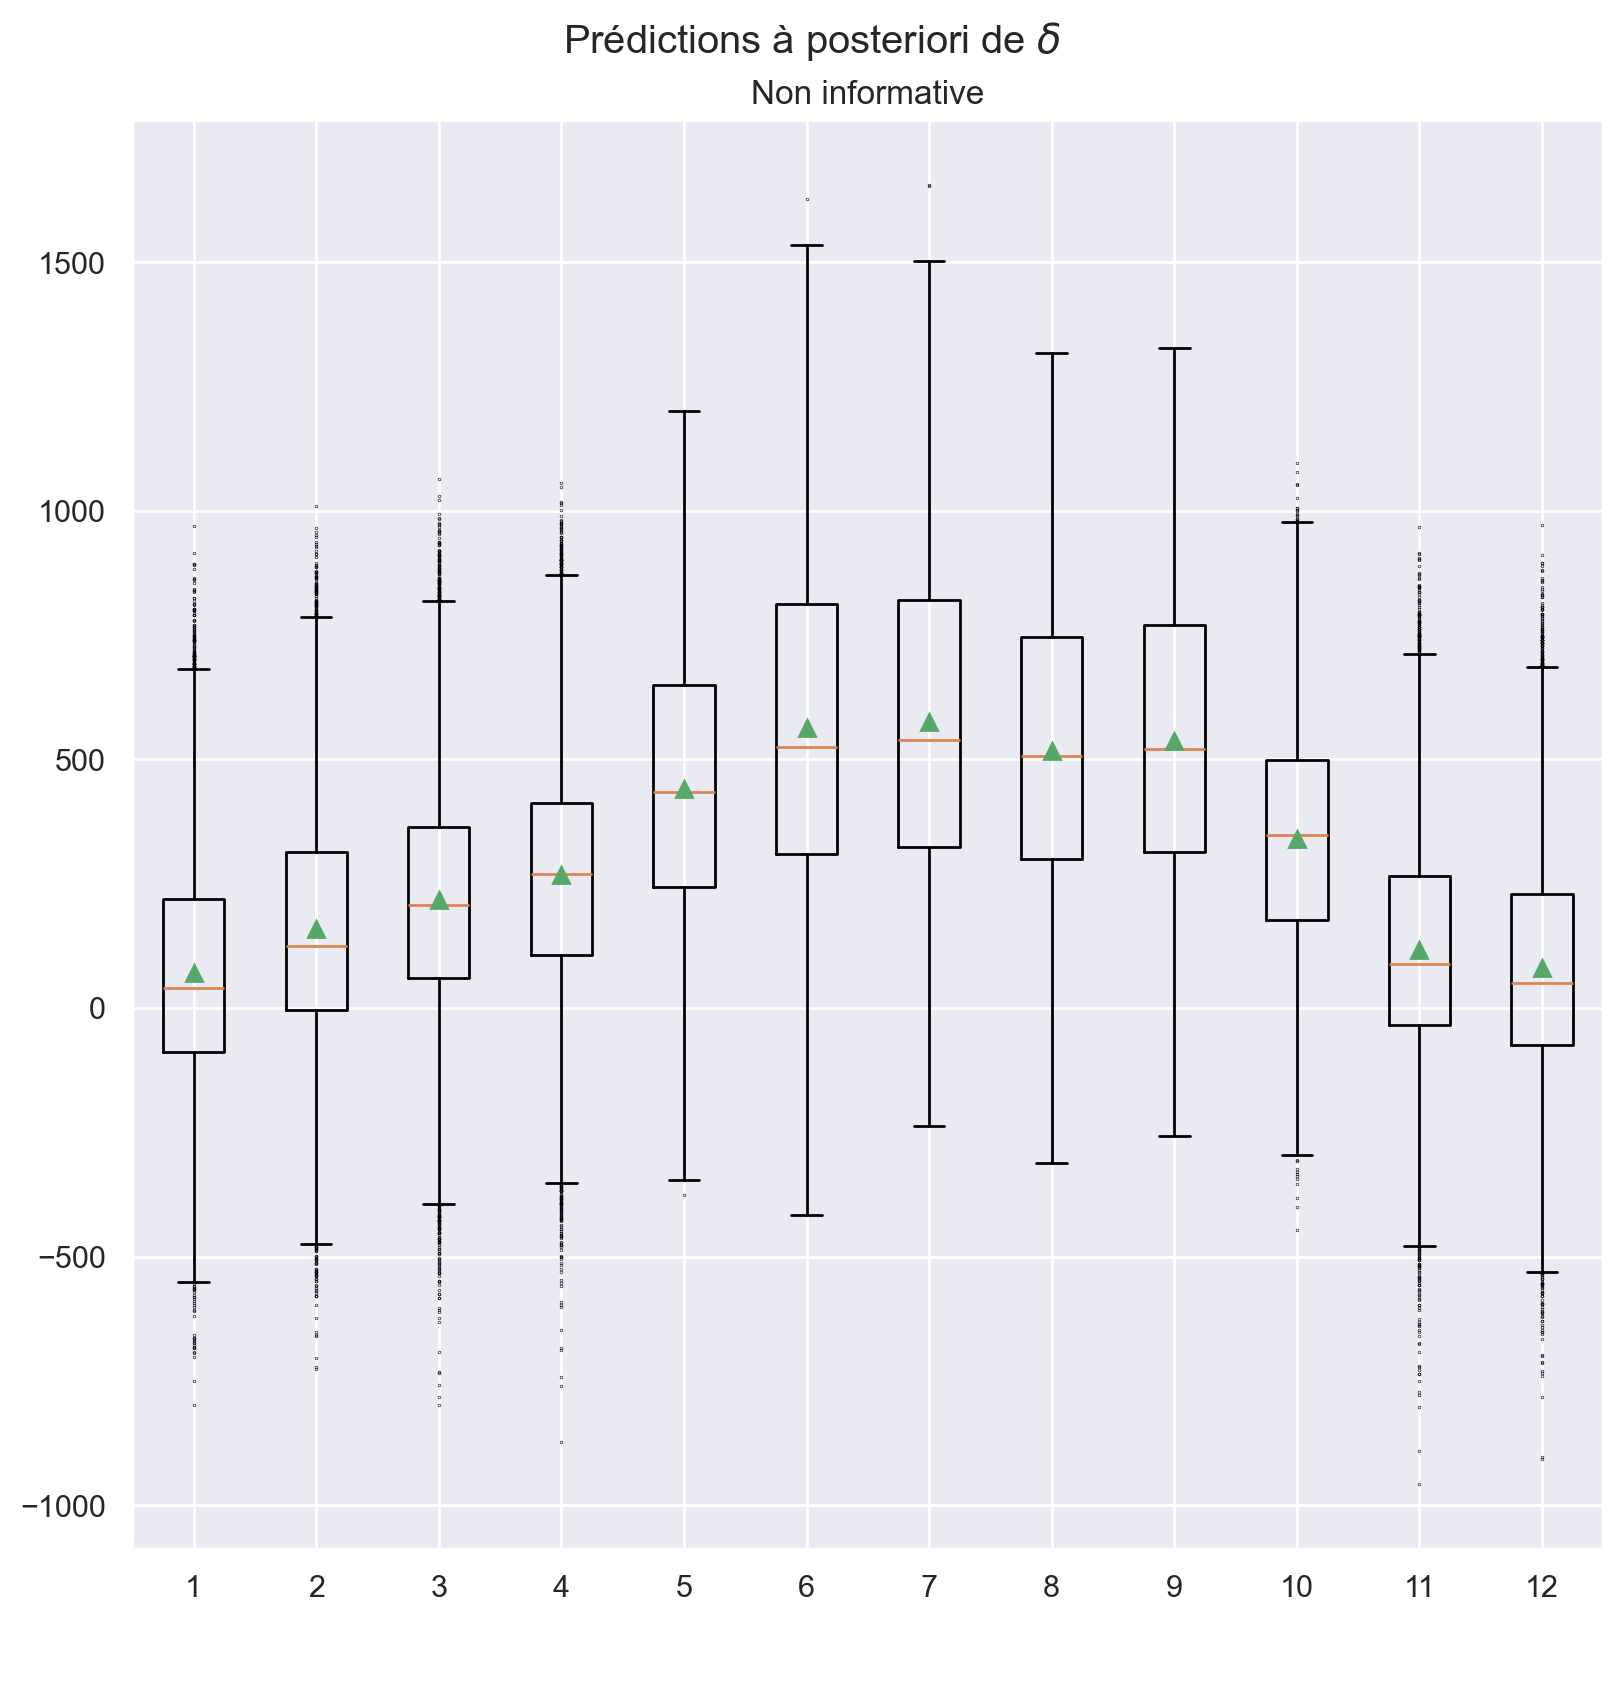

In [35]:
# Prédictions pour chaque prior

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

fig.suptitle(r"Prédictions à posteriori de $\delta$")

ax.boxplot(delta_pred_NI, positions = range(1, n+1), flierprops = dict(markersize = 0.2), showmeans=True);
ax.set_title("Non informative");

lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = "lower center", bbox_to_anchor = (0.5, -0.05));

plt.show()

#### Rapport $\delta(x)$/y(x)

In [36]:
ratio_NI = np.zeros((chains*n_draws, n))

for i in range(n):
    ratio_NI[:,i] = delta_pred_NI[:,i]/y[i]

ratio_NI = ratio_NI.ravel()

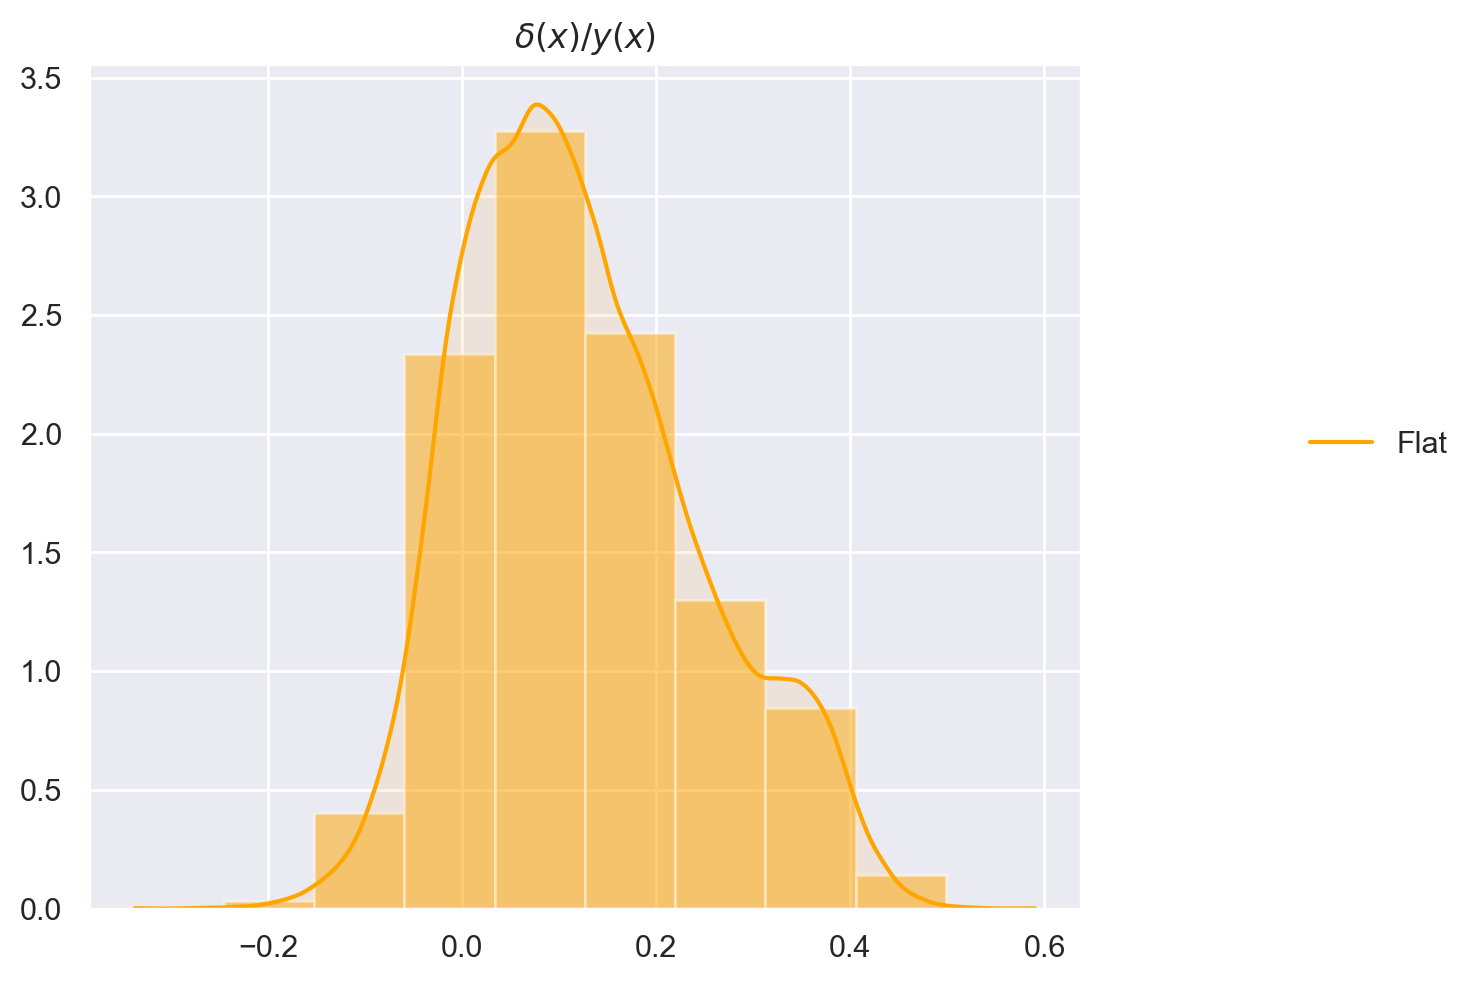

In [37]:
sns.set()

tt_NI, kde_NI = az.kde(ratio_NI)
labels = ["Flat", "Weakly Informative", "Specific Informative"]

# Tracé des distributions à posteriori
plt.hist(ratio_NI, color = "orange", density = True, alpha = 0.5);
plt.plot(tt_NI, kde_NI, color = "orange", label = labels[0]);
plt.fill_between(tt_NI, kde_NI, 0, color = 'orange', alpha = 0.1);
plt.title(r"$\delta(x)/y(x)$")

plt.legend(loc = "lower center", bbox_to_anchor = (1.3, 0.5));

plt.show()

## <p style="text-align: center;">FIN</p>